In [1]:
%%capture
!pip install yfinance
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os 
import gc
import random
import shutil

import h5py
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import yfinance as yf
import talib as talib
from tqdm import tqdm

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras import backend as K 
from keras.utils import Sequence
from tensorflow.keras.initializers import HeNormal
import tensorflow as tf

In [5]:
#https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Seed value
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [6]:
global base_folder_path
base_folder_path = "/content/drive/MyDrive/IAQF"

global data_split
data_split = "2021-01-01"

date_format = "%Y-%m-%d"

In [7]:
def clear_session():
  folders = ["/content/drive/MyDrive/IAQF/Actions", "/content/drive/MyDrive/IAQF/Model", "/content/drive/MyDrive/IAQF/H5"]
  for folder in folders:
    for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))
clear_session()

In [8]:
def LoadData(tickerlist, period='10y'):
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = tickerlist,

            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = "1d",

            # Whether to ignore timezone when aligning ticker data from 
            # different timezones. Default is False.
            ignore_tz = False, # !!

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = False,  

            # attempt repair of missing data or currency mixups e.g. $/cents
            repair = False,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = False,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    data.columns = [' '.join(col).strip() for col in data.columns.values]    
    return data

def CleanPriceData(data): # for cleaning price data of 1 pair
    df1 = data.iloc[:,0].copy(deep=True)
    df1.index = df1.index.values.astype('M8[D]')
    df1 = pd.DataFrame(df1.dropna())
    df2 = data.iloc[:,1].copy(deep=True)
    df2.index = df2.index.values.astype('M8[D]')
    df2 = pd.DataFrame(df2.dropna())
    data = df1.join(df2,how='left')
    return data

def CleanData(data): #for cleaning data of 1 pair
    
    # 1) separate the data
    df1 = data.iloc[:,0].copy(deep=True)
    df1.index = df1.index.values.astype('M8[D]')
    df1 = pd.DataFrame(df1.dropna())
    df2 = data.iloc[:,1].copy(deep=True)
    df2.index = df2.index.values.astype('M8[D]')
    df2 = pd.DataFrame(df2.dropna())
    
    # 2) cal logreturn
    df1 = 100*np.log(df1/df1.shift(1))
    df2 = 100*np.log(df2/df2.shift(1))
    
    # 3) join
    data = df1.join(df2,how='left',lsuffix=1)
    
    # 4) dropna
    data.dropna(inplace=True)
    return data

In [9]:
class StratGenerator(Sequence):
  def __init__(self, h5_shard, x_name, y_name, pre_load = False):
    self.h5_shard = h5_shard
    self.x = self.h5_shard[x_name]
    self.y = self.h5_shard[y_name]
    if pre_load: self.pre_load_data()
    self.number_samples = len(self.x)
    self.batch_size = 8
    self.idxs = np.arange(len(self))

  def pre_load_data(self):
    self.x = self.x[:]
    self.y = self.y[:]

  def on_epoch_end(self):
    np.random.shuffle(self.idxs)
    
  def __len__(self):
    return int(np.floor(self.number_samples/self.batch_size))

  def __getitem__(self, index):
    start_idx = self.idxs[index] * self.batch_size
    end_idx = start_idx + self.batch_size
    if end_idx > len(self.x): raise StopIteration
    return self.__data_generation(start_idx, end_idx)

  def __data_generation(self, start_idx, end_idx):
    x = np.expand_dims(self.x[start_idx:end_idx],1)
    y = self.y[start_idx:end_idx]
    return x,y

def fetch_data(pair1, pair2):
  data = yf.download([pair1,pair2], start = "2010-01-01", group_by = 'ticker')
  data.columns = [' '.join(col).strip() for col in data.columns.values]
  logreturn = 100 * np.log(data/data.shift(1))

  data = np.log(data)
  data.replace([np.inf, -np.inf], np.nan, inplace = True)
  data.dropna(inplace = True)
  return data, logreturn

def generate_features(data, pair1, pair2):
  data_split = "2021-01-01"
  train_data = data[data.index < data_split].copy()
  test_data = data[data.index >= data_split].copy()
  S1 = train_data[f"{pair2} Adj Close"]
  S2 = train_data[f"{pair1} Adj Close"]

  S1 = sm.add_constant(S1)
  results = sm.OLS(S2, S1).fit()
  S1 = train_data[f"{pair2} Adj Close"]
  beta = results.params[f"{pair2} Adj Close"]
  
  data["OPEN_SPREAD"] =   data[f"{pair1} Open"] -   beta * data[f"{pair2} Open"]
  data["HIGH_SPREAD"] =   data[f"{pair1} High"] -   beta * data[f"{pair2} High"]
  data["LOW_SPREAD"] =    data[f"{pair1} Low"] -    beta * data[f"{pair2} Low"]
  data["CLOSE_SPREAD"] =  data[f"{pair1} Close"] -  beta * data[f"{pair2} Close"]
  data["VOLUME_SPREAD"] = data[f"{pair1} Volume"] - beta * data[f"{pair2} Volume"]

  open =   data["OPEN_SPREAD"].values
  high =   data["HIGH_SPREAD"].values
  low =    data["LOW_SPREAD"].values
  close =  data["CLOSE_SPREAD"].values
  volume =(data["VOLUME_SPREAD"].values).astype(np.float64)

  #Overlap studies 
  data["UPPER"], data["MIDDLE"], data["LOWER"] = talib.BBANDS(close, matype=talib.MA_Type.T3)
  data["SAR"] =   talib.SAR(high, low, acceleration=0, maximum=0)
  data["SMA"] =   talib.SMA(close, 5)
  data["EMA"] =   talib.EMA(close, 10)
  data["TRIMA"] = talib.TRIMA(close, 10)

  #Momentum indicators 
  data["ADX"] =       talib.ADX(high, low, close)
  data["ADXR"] =      talib.ADXR(high, low, close)
  data["APO"] =       talib.APO(close)
  data["ARRONOSC"] =  talib.AROONOSC(high, low)
  data["BOP"] =       talib.AROONOSC(high, low)
  data["CCI"] =       talib.CCI(high, low, close)
  data["MACD1"],data["MACD2"],data["MACD3"] = talib.MACD(close)
  data["MOM"] =       talib.MOM(close)
  data["PPO"] =       talib.PPO(close)
  data["ROCP"] =      talib.ROCP(close)
  data["ROCR"] =      talib.ROCR(close)
  data["RSI"] =       talib.RSI(close)
  data["STOCH_SLOW"], data["STOCH_FAST"] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  data["STOCH_RSI1"], data["STOCH_RSI2"] = talib.STOCHRSI(close)
  data["ULT_OSC"] =   talib.ULTOSC(high, low, close)
  data["WILLR"] =     talib.WILLR(high, low, close)

  #Volume indicators 
  data["AD"] = talib.AD(high, low, close, volume)
  data["ADOSC"] = talib.ADOSC(high, low, close, volume)
  data["OBV"] = talib.OBV(close, volume)

  #Volatility indicators 
  data["ATR"] = talib.ATR(high, low, close)
  data["NATR"] = talib.NATR(high, low, close)

  return data

def save_to_h5(data, pair1, pair2):
  data.replace([np.inf, -np.inf], np.nan, inplace = True)
  data.dropna(inplace=True)

  train_data = data[data.index < data_split].copy()[data.columns[12:]]
  test_data = data[data.index >= data_split].copy()[data.columns[12:]]

  scaler = StandardScaler()
  scaler.fit(train_data)
  X_train = scaler.transform(train_data)
  X_test = scaler.transform(test_data)
  X_test = X_test[:-1, :]

  Y = data["CLOSE_SPREAD"].shift(-1)
  Y.dropna(inplace = True)

  Y_train = Y[Y.index < data_split]
  Y_test = Y[Y.index >= data_split]

  global Y_train_min
  global Y_train_max
  Y_train_min = Y_train.min()
  Y_train_max = Y_train.max()

  Y_train = (Y_train - Y_train_min) / (Y_train_max - Y_train_min)
  Y_test = (Y_test - Y_train_min) / (Y_train_max - Y_train_min)

  for obj in gc.get_objects():
    if isinstance(obj, h5py.File): 
        try:
            obj.close()
        except:
            pass 
  h5_base_path = os.path.join(base_folder_path, "H5")

  h5f_x_train = h5py.File(os.path.join(h5_base_path, f"train_{pair1}_{pair2}.h5"), 'w')
  h5f_x_train.create_dataset(f'x_train_{pair1}_{pair2}', data=X_train.astype(np.float32))
  h5f_x_train.create_dataset(f'y_train_{pair1}_{pair2}', data=Y_train.astype(np.float32))
  h5f_x_train.close()

  h5f_x_test = h5py.File(os.path.join(h5_base_path, f"test_{pair1}_{pair2}.h5"), 'w')
  h5f_x_test.create_dataset(f'x_test_{pair1}_{pair2}', data=X_test.astype(np.float32))
  h5f_x_test.create_dataset(f'y_test_{pair1}_{pair2}', data=Y_test.astype(np.float32))
  h5f_x_test.close()

  return X_test, test_data

def load_generators(pair1, pair2):
  h5_base_path = os.path.join(base_folder_path, "H5")
  index = f"{pair1}_{pair2}"

  shard_path_train = os.path.join(h5_base_path, f"train_{pair1}_{pair2}.h5")
  f_train = h5py.File(shard_path_train)
  x_name_train = f"x_train_{index}"
  y_name_train = f"y_train_{index}"

  shard_path_val = os.path.join(h5_base_path, f"test_{pair1}_{pair2}.h5")
  f_val = h5py.File(shard_path_val)
  x_name_val = f"x_test_{index}"
  y_name_val = f"y_test_{index}"

  Generator_train = StratGenerator(f_train, x_name_train, y_name_train, pre_load=True)
  Generator_test = StratGenerator(f_val, x_name_val, y_name_val, pre_load = True)
  return Generator_train, Generator_test

def generate_model(Generator_train, Generator_test, pair1, pair2):
  K.clear_session()
  if 'model' in locals(): del model
  if 'tpu_model' in locals(): del tpu_model
  seed = 1
  early_stopping = EarlyStopping(monitor='val_mse', patience=5, mode='auto', restore_best_weights=False)

  model = Sequential()
  seed = 1
  model.add(LSTM(8, input_dim=Generator_train.x.shape[1], return_sequences=True, kernel_initializer = HeNormal(seed=seed)))
  model.add(Dropout(.05))
  model.add(LSTM(8, return_sequences=False, kernel_initializer = HeNormal(seed=seed)))
  model.add(Dropout(.05))
  model.add(Dense(1, activation='relu', kernel_initializer = HeNormal(seed=seed)))
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  #model.summary()

  load_weights = False
  model_base_path = os.path.join(base_folder_path, "Model")
  model_h5_path = os.path.join(model_base_path, f"{pair1}_{pair2}_weights.h5")
  model_json_path = os.path.join(model_base_path, f"{pair1}_{pair2}_weights.json")

  if load_weights: model.load_weights(model_h5_path)
  else: history = model.fit(
      Generator_train,
      validation_data=Generator_test, 
      epochs=75,
      callbacks = [early_stopping],
      verbose = 0
  )

  model_json = model.to_json()
  with open(model_json_path, "w") as json_file:
      json_file.write(model_json)

  model.save_weights(model_h5_path)

  return model, history

def generate_preds(model, X_test, test_data, data, pair1, pair2):
  test_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_test,1))).batch(32)
  preds = model.predict(test_dataset)

  preds = pd.DataFrame(index = test_data.index.values[0:-1], data = preds, columns = ["PREDS"])
  preds = pd.merge(preds, data[data.index >= data_split][["CLOSE_SPREAD",f"{pair1} Close", f"{pair2} Close"]], left_index = True, right_index = True)
  preds["PREDS"] = preds["PREDS"].values * (Y_train_max - Y_train_min) + Y_train_min
  preds["Dif"] = preds['PREDS'] - preds['CLOSE_SPREAD']
  return preds

def generate_actions(preds, logreturn, pair1, pair2):
  actions = []
  position = 0
  for i in range(preds.shape[0]):
    if position == 0:
      if preds.iloc[i]["Dif"] > 0:
        actions.append([1,-1])
        position = 1
      else:
        actions.append([-1,1])
        position = -1
    else:
      if position == -1:
        if preds.iloc[i]["Dif"] > 0:
          actions.append([1,-1])
          position = 0
        else:
          actions.append([0,0])
      else:
        if preds.iloc[i]["Dif"] < 0:
          actions.append([-1,1])
          position = 0
        else:
          actions.append([0,0])

    
  actions = pd.DataFrame(actions, index=preds.index, columns=["^RUT","^GSPC"])
  logreturn = logreturn[logreturn.index.isin(actions.index)]

  base_path = os.path.join(base_folder_path, "Actions")
  actions.to_csv(os.path.join(base_path, f"{pair1}_{pair2}_actions.csv"))
  logreturn.to_csv(os.path.join(base_path, f"{pair1}_{pair2}_logreturns.csv"))

pairs = [
['^GSPC', '^IXIC'],
['^IXIC', '^DJI'] ,
['^DJI', '^GSPC'] ,
["^GSPC", "^RUT"]
]



historys = {}
for pair in tqdm(pairs):
  pair1, pair2 = pair[0], pair[1]
  print(pair1, pair2)

  #Fetch data from yfinance and generate features
  data, logreturn = fetch_data(pair1, pair2) 
  data = generate_features(data, pair1, pair2)

  #Save to H5 file format and load generatros
  X_test, test_data = save_to_h5(data, pair1, pair2)
  Generator_train, Generator_test = load_generators(pair1,pair2)

  #Create model and train it on the generators
  model, history = generate_model(Generator_train, Generator_test, pair1, pair2)
  historys[pair1 + "_" + pair2] = history

  #Use the model to generate predictions and trading strategy
  preds = generate_preds(model, X_test, test_data, data, pair1, pair2)
  generate_actions(preds, logreturn, pair1, pair2)

  0%|          | 0/4 [00:00<?, ?it/s]

^GSPC ^IXIC
[*********************100%***********************]  2 of 2 completed


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


17/17 [==============================] - 1s 2ms/step


 25%|██▌       | 1/4 [02:15<06:47, 135.69s/it]

^IXIC ^DJI
[*********************100%***********************]  2 of 2 completed


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


17/17 [==============================] - 1s 4ms/step


 50%|█████     | 2/4 [03:02<02:46, 83.48s/it] 

^DJI ^GSPC
[*********************100%***********************]  2 of 2 completed


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


17/17 [==============================] - 4s 6ms/step


 75%|███████▌  | 3/4 [04:39<01:29, 89.62s/it]

^GSPC ^RUT
[*********************100%***********************]  2 of 2 completed


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


17/17 [==============================] - 2s 3ms/step


100%|██████████| 4/4 [06:30<00:00, 97.61s/it]


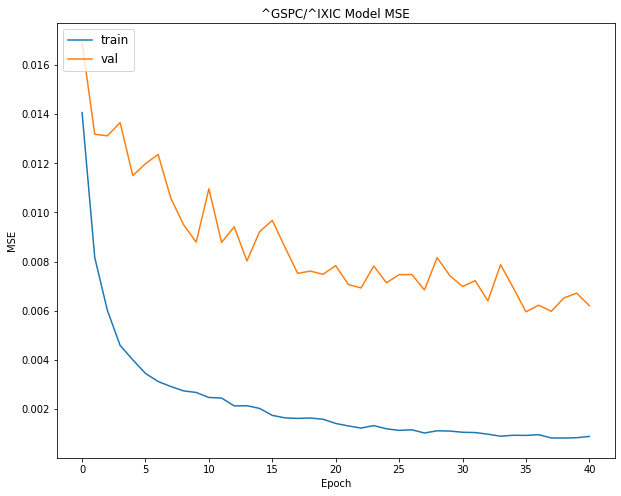

In [14]:
pair1 = "^GSPC"
pair2 = "^IXIC"
plt.figure(figsize=(10,8))

history = historys[pair1 + "_" + pair2]
plt.plot(history.history['mse'][1:])
plt.plot(history.history['val_mse'][1:])

plt.title(f'{pair1}/{pair2} Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left', prop={"size":12})
plt.show()

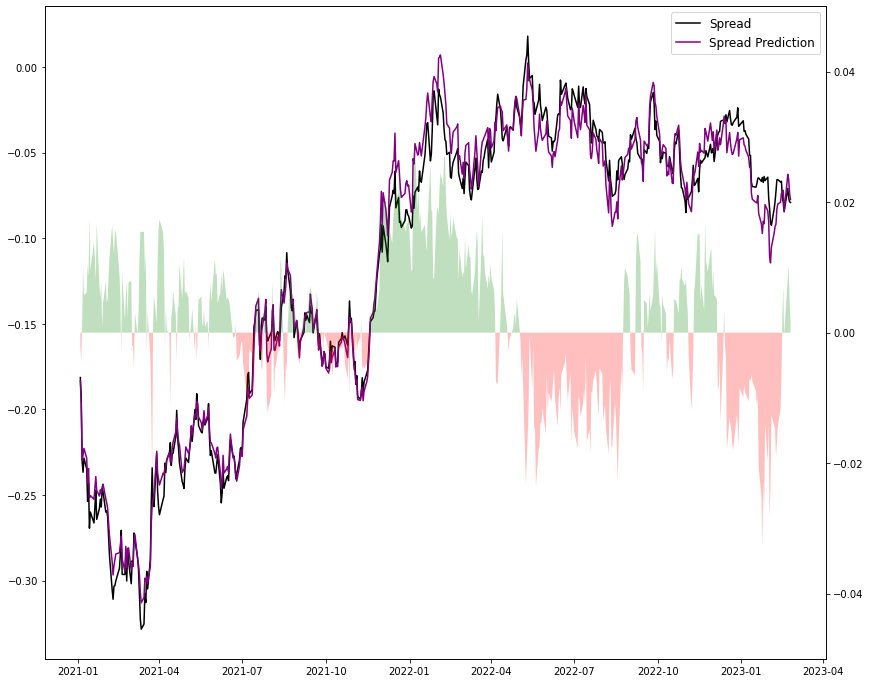

In [15]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylim([-.05, .05])


ax1.plot(preds["CLOSE_SPREAD"], color = "black", label = "Spread")
ax1.plot(preds['PREDS'], color = "purple", label = "Spread Prediction")

ax2.fill_between(preds['Dif'].index, 0.0, preds['Dif'], where=preds['Dif']>0, facecolor='green', interpolate=True, alpha = .25)
ax2.fill_between(preds['Dif'].index, 0.0, preds['Dif'], where=preds['Dif']<0, facecolor='red', interpolate=True, alpha = .25)

_ = ax1.legend(prop={"size":12})
plt.show()

In [16]:
def Trade(actions,logreturns, weight = [1,1]): # not finished, need reinvestment part (?)
    # assumptions
    capital = 100
    #reinv_ratio = 0
    w = [weight[0],weight[1]]
    
    portfolio = pd.DataFrame(columns = logreturns.columns,index=actions.index)
    
    # day 0 balance
    portfolio['Cash'] = 0
    portfolio.iloc[:,:2] = 0
    #reinvest = 0
    
    for i in range(actions.shape[0]):
        if i != 0:
            portfolio.iloc[i,2] = portfolio.iloc[i-1,2]
        
        if portfolio.iloc[i-1,0] == 0:
            # if no stocks in portfolio 
            portfolio.iloc[i,0] = actions.iloc[i,0]*w[0]*capital
            portfolio.iloc[i,1] = actions.iloc[i,1]*w[1]*capital
            portfolio.iloc[i,2] = portfolio.iloc[i,2] - portfolio.iloc[i,0] - portfolio.iloc[i,1]
        else:
            # if have positions 
            # calculate day-end
            portfolio.iloc[i,0] = portfolio.iloc[i-1,0]+(np.exp(logreturns.iloc[i,0]/100)-1)*portfolio.iloc[i-1,0]
            portfolio.iloc[i,1] = portfolio.iloc[i-1,1]+(np.exp(logreturns.iloc[i,1]/100)-1)*portfolio.iloc[i-1,1]
            
            # if not hold
            if actions.iloc[i,0] != 0:
                act0 = actions.iloc[i,0]*abs(portfolio.iloc[i,0])
                act1 = actions.iloc[i,1]*abs(portfolio.iloc[i,1])
                portfolio.iloc[i,2] = portfolio.iloc[i,2]-act0-act1
                portfolio.iloc[i,0] = portfolio.iloc[i,0]+act0
                portfolio.iloc[i,1] = portfolio.iloc[i,1]+act1
                #reinvest = np.max([reinv_ratio*(-act0-act1),0])


    print('weight of '+logreturns.columns[0]+': '+ str(w[0]))
    print('weight of '+logreturns.columns[1]+': '+ str(w[1]))
    print('default long spread value:')
    print(capital*w[0]-capital*w[1])

    portfolio['PnL'] = pd.DataFrame(portfolio.sum(axis=1))
    portfolio['Daily Return'] = 100*(portfolio['PnL']/portfolio['PnL'].shift(1) - 1)
    portfolio['daily logreturn'] = np.log(portfolio['PnL']/portfolio['PnL'].shift(1))*100
    portfolio['std'] = portfolio['Daily Return'].rolling(252).std()
    portfolio['average return'] = portfolio['daily logreturn'].rolling(252).mean()
    portfolio['average return'] = (np.exp(portfolio['average return']/100)-1)*100
    portfolio['Sharpe'] = portfolio['average return']/portfolio['std']*100
    portfolio = portfolio.drop(['daily logreturn','average return'],axis=1)
    
    plt.plot(portfolio['PnL'])
    plt.ylabel('Profit and Loss (USD)')
    plt.show()
    
    plt.plot(portfolio['Sharpe'].dropna())
    plt.ylabel('Sharpe (daily, percent)')
    plt.show()
    
    return portfolio


weight of ^GSPC Close: 1
weight of ^IXIC Close: 1
default long spread value:
0


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


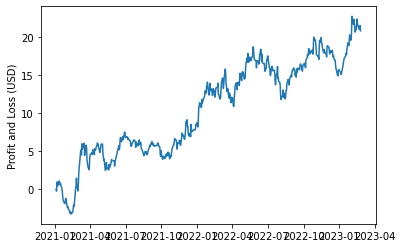

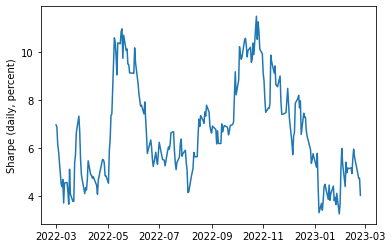

weight of ^IXIC Close: 1
weight of ^DJI Close: 1
default long spread value:
0


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


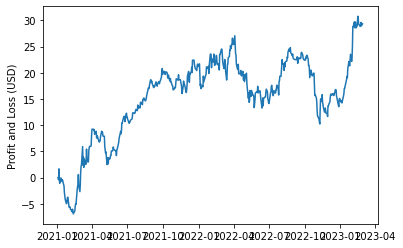

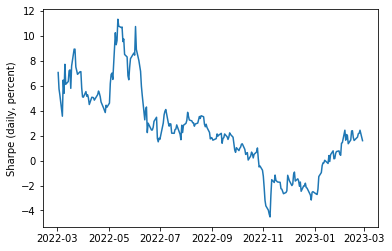

weight of ^DJI Close: 1
weight of ^GSPC Close: 1
default long spread value:
0


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


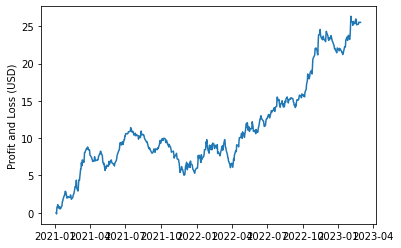

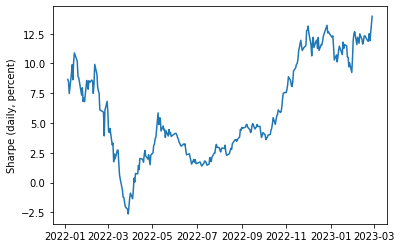

weight of ^GSPC Close: 1
weight of ^RUT Close: 1
default long spread value:
0


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


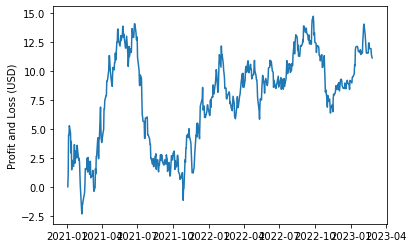

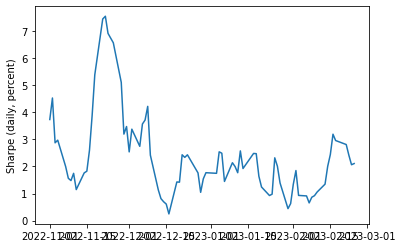

In [17]:
pairs = list(historys.keys())
portfolios = {}

for pair in pairs:
  pair_list = pair.split("_")
  pair1, pair2 = pair_list[0], pair_list[1]

  base_path = "/content/drive/MyDrive/IAQF/Actions"
  actions = pd.read_csv(os.path.join(base_path, f"{pair1}_{pair2}_actions.csv"))
  logreturn = pd.read_csv(os.path.join(base_path, f"{pair1}_{pair2}_logreturns.csv"))

  actions.set_index(actions.columns[0], inplace = True)
  actions.index = pd.to_datetime(actions.index)
  logreturn.set_index(logreturn.columns[0], inplace = True)
  logreturn.index = pd.to_datetime(actions.index)

  portfolio = Trade(actions,logreturn[[f"{pair1} Close", f"{pair2} Close"]])
  portfolios[pair] = portfolio

[*********************100%***********************]  1 of 1 completed


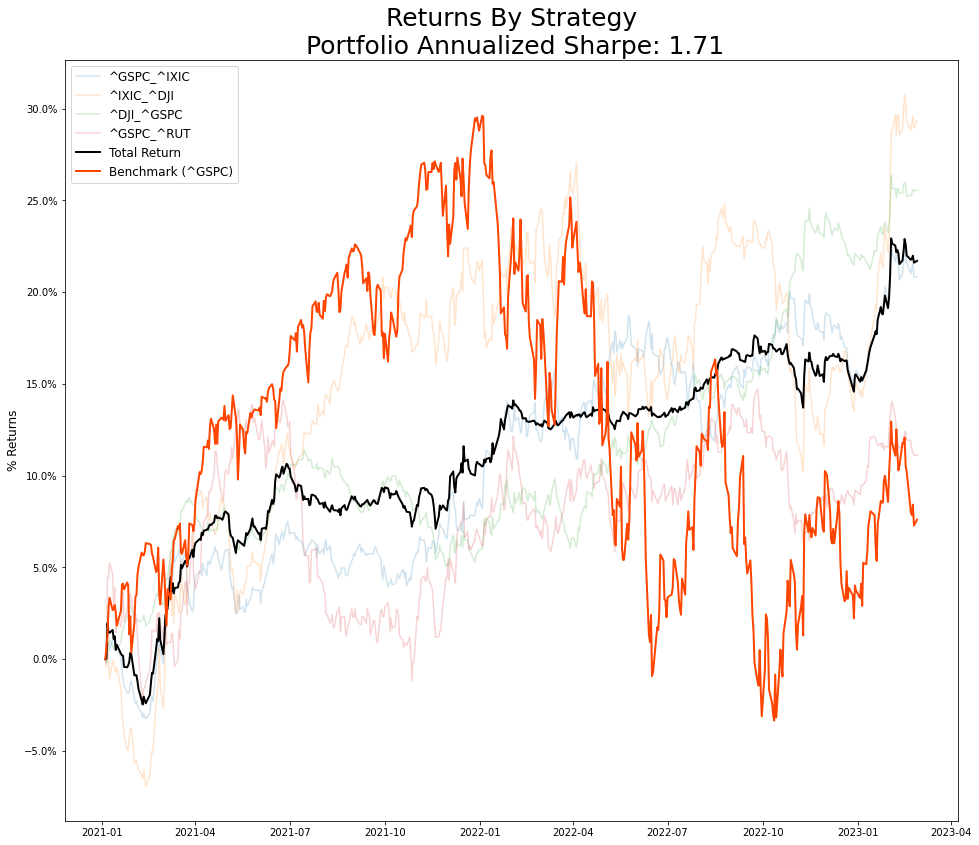

In [18]:
PnLs = [portfolios[pair]["PnL"] for pair in pairs]
Returns = pd.concat(PnLs, axis = 1)
Returns.fillna(method='ffill', inplace = True)
Returns.columns = pairs
Returns["Total Return"] = Returns.sum(axis = 1)
Returns["Total Return"] = Returns["Total Return"] / (100*len(pairs))

for pair in pairs:
  Returns[pair] = (Returns[pair]) / 100

Returns

fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(111)

#Calculate percentage Returns
for pair in pairs:
  ax1.plot(Returns[pair]*100, label = pair, alpha = .2)

#Get Benchmark Returns 
sp500 = data = yf.download(["^GSPC"], start = "2010-01-01", group_by = 'ticker')
Returns = pd.merge(Returns, sp500[["Close"]], left_index = True, right_index = True)
Returns["Close"] = (Returns["Close"] - Returns["Close"].values[0]) / Returns["Close"].values[0]

ax1.plot(Returns["Total Return"]*100, label = "Total Return", color = "black", linewidth = 2)
ax1.plot(Returns["Close"]*100, label = "Benchmark (^GSPC)", color = "orangered", linewidth = 2)

daily_returns = Returns["Total Return"].diff().dropna().values
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns))*(252**(1/2))


ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylabel("% Returns", fontsize = 12)
plt.title(f"Returns By Strategy\n Portfolio Annualized Sharpe: {sharpe_ratio:.2f}", fontsize = 25)
_ = ax1.legend(prop={"size":12})

In [22]:
for col in Returns.columns:
  daily_returns = Returns[col].diff().dropna().values

  sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns))*(252**(1/2))
  total_return = Returns[col].values[-1]

  print(f"{col} Sharpe: {sharpe_ratio:.2f}, Total Returns: {total_return:.2f}")

^GSPC_^IXIC Sharpe: 1.07, Total Returns: 0.21
^IXIC_^DJI Sharpe: 0.92, Total Returns: 0.29
^DJI_^GSPC Sharpe: 1.83, Total Returns: 0.26
^GSPC_^RUT Sharpe: 0.45, Total Returns: 0.11
Total Return Sharpe: 1.71, Total Returns: 0.22
Close Sharpe: 0.17, Total Returns: 0.08
